In [1]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# Module 1: Signals

_Contents_
* [Trapezoidal Waveforms](#trapwfm)
* [Fourier Series Coefficients of a Trapezoidal Waveform](#trapwfmspec)
* [Plotting the Spectra of Fourier Series](#trapwfmspecplot)
* [Spectral Plots and Envelopes](#trapenvelope)


## Trapezoidal Waveforms <a class="anchor" id="trapwfm"></a>

A trapezoidal waveform is only one step more complicated than a perfect square wave.  The additional degrees of freedom we obtain with the trapezoidal shape are very useful.  Currently, we will consider the following parameters.
- *Trise* ($\tau_r$): rise time of the signal
- *Tfall* ($\tau_f$): fall time of the signal
- *T* ($T$): Period of the waveform
- *D*: duty cycle of the signal (or the ratio of the time spent on and off, at 1 and 0).  50% duty cycle is ideal.
- *Tpulse* ($\tau = D T$): Pulse width of the signal
- *A*: Amplitude of the waveform. (i.e. peak-to-peak is 2A)
- *A0* ($A_0$): DC offset


In [2]:
def trapezoidal_wfm(t, T, Trise=1e-15, Tfall=1e-15, D=0.5, A=1, A0=0, DEBUG=False):
    """Generate a trapezoidal waveform.  This method is far from unique, and is
    arguably less readable than if I had generated the same waveform with a 
    loop iteration for each signal period."""
    r0 = np.floor(t/T)
    r = t/T - r0 # Creates a periodic array ranging from 0 - 1 based on the 
    # period of the waveform.
    
    # Rising edge
    r_rise = Trise/T
    rslope_rise = 2*A/r_rise
    # Stay at A until hitting the falling edge, defined as r_mid below.

    # Then, fall back to -A 
    # Falling edge
    r_fall = Tfall/T
    rslope_fall = 2*A/r_fall
    # Stay at -A for the duration of the cycle (until r = 0 again)    
    
    # Midpoint, defined by the duty cycle, rise, and fall points.
    r_mid = r_rise/2 + D - r_fall/2 # r_mid is calculated later b/c of dependence on r_fall.

    if DEBUG:
        print(0, r_rise, r_mid, r_mid+r_fall, 1)

    # Each line of the following expression represents a phase in the waveform.
    # Line 1: Rising Edge
    # Line 2: High Level
    # Line 3: Falling Edge
    # Line 4: Low Level
    # Line 5: DC offset
    # The nature of this expression is that it is inherently periodic.
    x = ((r >= 0)&(r < r_rise))*(r*rslope_rise - A) \
        + ((r >= r_rise)&(r < r_mid))*A \
        + ((r >= r_mid)&(r < r_fall+r_mid))*(A - (r-r_mid)*rslope_fall) \
        + ((r >= r_fall+r_mid)&(r < 1))*(-A)\
        + A0
        
    return x


0 0.125 0.5 0.625 1
1.9997501249375311


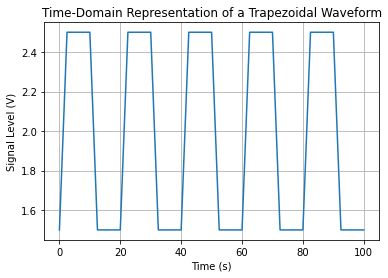

In [3]:
t = np.linspace(0,100,2001)
x = trapezoidal_wfm(t, 20, Trise=2.5, Tfall=2.5, D=0.5, A=0.5, A0=2, DEBUG=True)

fig, ax = plt.subplots(1,1)
ax.plot(t,x)
ax.grid(True)
ax.set_title('Time-Domain Representation of a Trapezoidal Waveform')
ax.set_ylabel('Signal Level (V)') # I am arbitrarily declaring this signal a voltage.
ax.set_xlabel('Time (s)')

print(np.mean(x))

The trapezoida waveform from `trapezoidal_wfm` was broken into five pieces.  Two of those pieces, the rising and falling edges, are ramps.  The other three components are constant values.  The high level and the low level mark times when the waveform is at a constant level, and the DC offset is a constant adder for all time.

This representation is not the only way to mark the trapezoidal wave.  For the purposes of calculating the frequency components of the waveform, we can write the waveform entirely out of scaled unit ramp functions.  This version of the waveform is more useful when we attempt to calculate the spectrum of an arbitrary bit pattern generated out of trapezoidal-shaped pulses.  The function below, `trapezoidal_wfm2`, takes the same arguments as the previous version, but creates the waveform using only ramp type expressions on each line of the calculation of `x`. 

In [4]:
def trapezoidal_wfm2(t, T, Trise=1e-15, Tfall=1e-15, D=0.5, A=1, A0=0, DEBUG=False):
    """Generate a trapezoidal waveform.  This method is far from unique, and is
    arguably less readable than if I had generated the same waveform with a 
    loop iteration for each signal period."""
    r0 = np.floor(t/T)
    r = t/T - r0 # Creates a periodic array ranging from 0 - 1 based on the 
    # period of the waveform.
    
    # Rising edge
    r_rise = Trise/T
    rslope_rise = 2*A/r_rise
    # Stay at A until hitting the falling edge, defined by r_mid (calculated after r_fall).
    # Then, fall back to -A 
    # Falling edge
    r_fall = Tfall/T
    rslope_fall = 2*A/r_fall
    # Stay at -A for the duration of the cycle (until r = 0 again)
    # 
    # Midpoint, defined by the duty cycle, rise, and fall points.
    r_mid = r_rise/2 + D - r_fall/2 # r_mid is calculated later b/c of dependence on r_fall.
  
    if DEBUG:
        print(0, r_rise, r_mid, r_mid+r_fall, 1)
    
    # Each line is a different unit ramp with a scaling factor.
    # Line 1: Rising edge ramp
    # Line 2: Ramp to counter the rising edge ramp
    # Line 3: Falling edge ramp
    # Line 4: Ramp to counter the falling edge ramp
    # Line 5: DC offset
    # The nature of this expression is that it is inherently periodic.
    x = (r >= 0)*(r*rslope_rise - A) \
        + (r >= r_rise)*(-(r-r_rise)*rslope_rise) \
        + (r >= r_mid)*(-(r-r_mid)*rslope_fall) \
        + (r >= r_fall+r_mid)*((r-(r_fall+r_mid))*rslope_fall)\
        + A0
        
    return x


0 0.125 0.5 0.625 1
1.9997501249375311


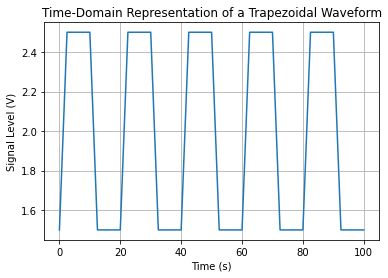

In [5]:
t = np.linspace(0,100,2001)
x = trapezoidal_wfm2(t, 20, Trise=2.5, Tfall=2.5, D=0.5, A=0.5, A0=2, DEBUG=True)

fig, ax = plt.subplots(1,1)
ax.plot(t,x)
ax.grid(True)
ax.set_title('Time-Domain Representation of a Trapezoidal Waveform')
ax.set_ylabel('Signal Level (V)') # I am arbitrarily declaring this signal a voltage.
ax.set_xlabel('Time (s)')

print(np.mean(x))

## Fourier Series Coefficients of a Trapezoidal Waveform <a class="anchor" id="trapwfmspec"></a>

As a periodic waveform, the trapezoidal waveform can be represented by a Fourier series.  The function `trapezoidal_fs_coeff` calculates the `n`th coefficient for a trapezoidal waveform.  This function calculates double-sided spectral components rather than single-sided.  
$$D_n = \frac{1}{T_0} \int_0^{T_0} x(t) e^{-2\pi n f_0 t} dt,\ \forall n \in \mathbb{Z}$$
Using a sequence of the coefficients with the exponential basis function,
$$x(t) = \sum_{n=-\infty}^\infty D_n e^{j 2\pi n f_0 t}\ ,$$
The trapezoidal waveform can be reconstructed, albeit in a band-limited fashion.

In [6]:
# Trapezoidal Fourier Series Coefficient Calculations
def trapezoidal_fs_coeff(T, n, Trise=1e-15, Tfall=1e-15, D=0.5, A=1, A0=0, print_coeff=False, zero_tol=1e-18):
    """
    $$D_n = \frac{1}{T_0} \int_0^{T_0} x(t) e^{-j 2\pi n f_0 t} dt$$
    
    $$x(t) = \sum_{n=-\infty}^\infty D_n e^{j 2\pi n f_0 t}$$
    """
    # The DC term D_0 = A0.
    if n == 0:
        D0 = A0 + A*(2*D-1)
        return D0
    
    # The remainder of this function assume n > 0.  
    def const_term_integration(T, n, a, b):
        """
        $$I_0 = \int_a^b e^{-j 2\pi n f_0 t} dt$$
        """
        f0 = 1./T
        alpha = -2j*np.pi*n*f0
        I = 1./alpha * (np.e**(alpha*b) - np.e**(alpha*a))
        return I
    
    def ramp_term_integration(T, n, a, b):
        """
        $$I_1 = \int_a^b t e^{-j 2\pi n f_0 t} dt$$
        """
        f0 = 1./T
        alpha = -2j*np.pi*n*f0
        I = 1./alpha * (b*np.e**(alpha*b) - a*np.e**(alpha*a)) \
            - 1./(alpha*alpha) * (np.e**(alpha*b) - np.e**(alpha*a))
        return I
    
    Tpulse = D*T
    t1 = 0
    t2 = Trise
    t3 = Trise/2 + Tpulse - Tfall/2
    t4 = t3 + Tfall
    t5 = T

    Irise = (2*A/Trise) * ramp_term_integration(T, n, t1, t2) \
        + (A0 - A) * const_term_integration(T, n, t1, t2)
    Ihigh = (A0 + A) * const_term_integration(T, n, t2, t3)
    Ifall = (A0 + A + 2*A*t3/Tfall) * const_term_integration(T, n, t3, t4) \
        - (2*A/Tfall) * ramp_term_integration(T, n, t3, t4)
    Ilow = (A0 - A) * const_term_integration(T, n, t4, t5)
    
    Dn = (Irise + Ihigh + Ifall + Ilow)/T
    if np.abs(Dn) < zero_tol:
        Dn = 0. + 0j
    
    if print_coeff:
        print("D[%d] = %.3g at %.1f deg" % (n, np.abs(Dn), (180*np.angle(Dn)/np.pi)))
    return Dn

def trapezoidal_fs_approx(t, N, T, Trise=1e-15, Tfall=1e-15, D=0.5, A=1, A0=0, print_coeff=False, zero_tol=1e-18):
    """
    Approximate the time-domain waveform with an incomplete number of Fourier terms.
    """
    xapprox = np.zeros(t.shape, dtype=np.complex128)
    
    for n in range(-N, N+1):
        Dn = trapezoidal_fs_coeff(T, n, Trise, Tfall, D, A, A0, print_coeff=print_coeff, zero_tol=zero_tol)
        exp = np.e**(2j*np.pi*n*t/T)
        xapprox += Dn*exp
    
    return np.real(xapprox)


D[-10] = 0.0203 at 180.0 deg
D[-9] = 0.0175 at 126.0 deg
D[-8] = 0 at 0.0 deg
D[-7] = 0.0261 at -162.0 deg
D[-6] = 0.0455 at 144.0 deg
D[-5] = 0.0405 at 90.0 deg
D[-4] = 0 at 0.0 deg
D[-3] = 0.0723 at 162.0 deg
D[-2] = 0.157 at 108.0 deg
D[-1] = 0.224 at 54.0 deg
D[1] = 0.224 at -54.0 deg
D[2] = 0.157 at -108.0 deg
D[3] = 0.0723 at -162.0 deg
D[4] = 0 at 0.0 deg
D[5] = 0.0405 at -90.0 deg
D[6] = 0.0455 at -144.0 deg
D[7] = 0.0261 at 162.0 deg
D[8] = 0 at 0.0 deg
D[9] = 0.0175 at -126.0 deg
D[10] = 0.0203 at -180.0 deg


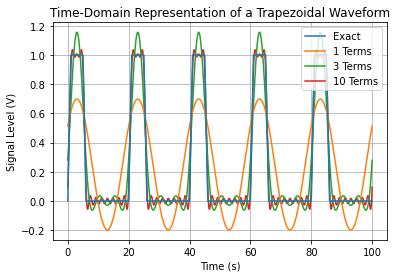

In [7]:
t = np.linspace(0,100,2001)
Na = 1
Nb = 3
Nc = 10
T = 20
Trise=1
Tfall=1
D=0.25
A=0.5
A0=0.5
x = trapezoidal_wfm2(t, T, Trise, Tfall, D, A, A0)
xa = trapezoidal_fs_approx(t, Na, T, Trise, Tfall, D, A, A0)
xb = trapezoidal_fs_approx(t, Nb, T, Trise, Tfall, D, A, A0)
xc = trapezoidal_fs_approx(t, Nc, T, Trise, Tfall, D, A, A0, print_coeff=True, zero_tol=1e-16)

fig, ax = plt.subplots(1,1)
ax.plot(t, x, label='Exact', zorder=5)
ax.plot(t, xa, label='%d Terms' % Na, zorder=4)
ax.plot(t, xb, label='%d Terms' % Nb, zorder=3)
ax.plot(t, xc, label='%d Terms' % Nc, zorder=2)
ax.grid(True)
ax.set_title('Time-Domain Representation of a Trapezoidal Waveform')
ax.set_ylabel('Signal Level (V)') # I am arbitrarily declaring this signal a voltage.
ax.set_xlabel('Time (s)')
ax.legend(loc='best')

The next plot is of the same waveform, but the view is focused on the ripples at the peak of one of the pulses.

(0.5, 1.2)

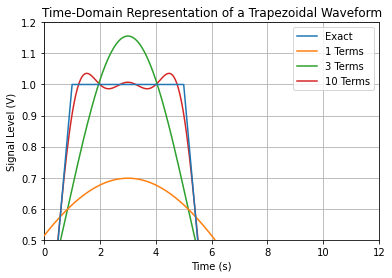

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(t, x, label='Exact', zorder=5)
ax.plot(t, xa, label='%d Terms' % Na, zorder=4)
ax.plot(t, xb, label='%d Terms' % Nb, zorder=3)
ax.plot(t, xc, label='%d Terms' % Nc, zorder=2)
ax.grid(True)
ax.set_title('Time-Domain Representation of a Trapezoidal Waveform')
ax.set_ylabel('Signal Level (V)') # I am arbitrarily declaring this signal a voltage.
ax.set_xlabel('Time (s)')
ax.legend(loc='best')
ax.set_xlim(0, T/2*1.2)
ax.set_ylim(A0, 1.2*(A+A0))

The figure above shows original time-domain waveform constructed from `trapezoidal_wfm2` and additional reconstructions using different numbers of Fourier series terms with `trapezoidal_fs_approx`.  The DC term, $D_0$, is included in all of the approximations, plus a number of sinusoidal terms.  Despite the earlier description that we are calculating double-sided spectral coefficients.  The assembly is done two at a time, taking both the positive, $D_k$, term and negative, $D_{-k}$, term at the same time.  For a real function,
$$D_{-k} = D_{k}^\ast\,$$
where $^\ast$ denotes the complex conjugate.

As more terms are added to the approximation, the waveform approaches the original time-domain waveform.  

D[-10] = 0 at 0.0 deg
D[-9] = 0.0025 at 180.0 deg
D[-8] = 0 at 0.0 deg
D[-7] = 0.00414 at 180.0 deg
D[-6] = 0 at 0.0 deg
D[-5] = 0.00811 at 180.0 deg
D[-4] = 0 at 0.0 deg
D[-3] = 0.0225 at 180.0 deg
D[-2] = 0 at 0.0 deg
D[-1] = 0.203 at 180.0 deg
D[1] = 0.203 at 180.0 deg
D[2] = 0 at 0.0 deg
D[3] = 0.0225 at -180.0 deg
D[4] = 0 at 0.0 deg
D[5] = 0.00811 at -180.0 deg
D[6] = 0 at 0.0 deg
D[7] = 0.00414 at -180.0 deg
D[8] = 0 at 0.0 deg
D[9] = 0.0025 at -180.0 deg
D[10] = 0 at 0.0 deg


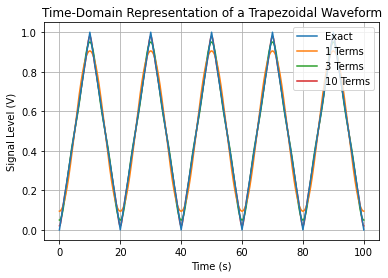

In [9]:
t = np.linspace(0,100,2001)
Na = 1
Nb = 3
Nc = 10
T = 20
Trise=T/2
Tfall=T/2
D=0.5
A=0.5
A0=0.5
x = trapezoidal_wfm2(t, T, Trise, Tfall, D, A, A0)
xa = trapezoidal_fs_approx(t, Na, T, Trise, Tfall, D, A, A0)
xb = trapezoidal_fs_approx(t, Nb, T, Trise, Tfall, D, A, A0)
xc = trapezoidal_fs_approx(t, Nc, T, Trise, Tfall, D, A, A0, print_coeff=True)

fig, ax = plt.subplots(1,1)
ax.plot(t, x, label='Exact', zorder=5)
ax.plot(t, xa, label='%d Terms' % Na, zorder=4)
ax.plot(t, xb, label='%d Terms' % Nb, zorder=3)
ax.plot(t, xc, label='%d Terms' % Nc, zorder=2)
ax.grid(True)
ax.set_title('Time-Domain Representation of a Trapezoidal Waveform')
ax.set_ylabel('Signal Level (V)') # I am arbitrarily declaring this signal a voltage.
ax.set_xlabel('Time (s)')
ax.legend(loc='best')

## Plotting the Spectra of Fourier Series <a class="anchor" id="trapwfmspecplot"></a>

Printing out the coefficients as the previous cells did with the coefficients used to generate the approximate waveforms is useful, but plots are much better to convey how the spectra changes with time.  Because the functions we have generated are periodic, the spectra associated with them are discrete.  The function `trapezoidal_fourier_series_spectrum` takes many of the same arguments that previous functions in this notebook have.  This function collects all of the complex spectral coefficients and returns a frequency vector and coefficient vector.  

In [10]:
def trapezoidal_fourier_series_spectrum(N, T, Trise=1e-15, Tfall=1e-15, D=0.5, A=1, A0=0, print_coeff=False, zero_tol=1e-18):
    """
    Return a frequency vector and coefficients a trapezoidal waveform.
    """
    xapprox = np.zeros(t.shape, dtype=np.complex128)
    
    nv = np.arange(-N, N+1)
    fv = nv/T # f0 = 1/T ==> fn = n f0
    Dv = []
    for n in nv:
        Dn = trapezoidal_fs_coeff(T, n, Trise, Tfall, D, A, A0, print_coeff=print_coeff, zero_tol=zero_tol)
        Dv.append(Dn)    
    return fv, np.array(Dv)


The next cell calculates and plots the spectra of a sawtooth, or triangle, waveform.  As shown previously, this waveform can be synthesized with the same trapezoidal functions.  For a sawtooth/triangle, $t_r = t_f = T/2$.  The waveform does not dwell at either extrema but immediately changes direction.   

/tmp/ipykernel_24756/1802583797.py:10: RuntimeWarning: divide by zero encountered in log10
  dB = lambda y_ : 20*np.log10(np.abs(y_))


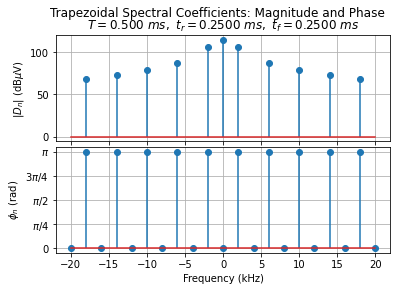

In [11]:
# Calculate some spectral elements.
N = 10
T = 1/2e3 # Note I changed T to create a 2 kHz fundamental waveform.
Trise=0.5*T
Tfall=0.5*T
D=0.5
A=0.5
A0=0.5
fv, Dv = trapezoidal_fourier_series_spectrum(N, T, Trise, Tfall, D, A, A0, zero_tol=1e-12)
dB = lambda y_ : 20*np.log10(np.abs(y_)) 
phase_raw = lambda y_ : (np.angle(y_))
phase = np.vectorize(lambda y_ : phase_raw(y_) if phase_raw(y_) > -np.pi*0.99 else phase_raw(y_) + 2*np.pi)

fig, axs = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.05)
ax = axs[0]
ax.stem(fv/1e3, dB(Dv/1e-6))
ax.grid(True)
ax.set_ylabel("$\|D_n\|$ (dB$\mu$V)")
ax.set_xticklabels([])
ax.set_title('$T = %.3f\ ms,\ t_r = %.4f\ ms,\ t_f = %.4f\ ms$' % tuple(np.array([T, Trise, Tfall])*1e3))

ax = axs[1]
ax.stem(fv/1e3, phase(Dv))
ax.set_yticks(np.arange(0,5)/4*np.pi)
ax.set_yticklabels(["0", "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$"])
ax.set_ylabel("$\phi_n$ (rad)")
ax.set_xlabel('Frequency (kHz)')
ax.grid(True)

fig.suptitle('Trapezoidal Spectral Coefficients: Magnitude and Phase')

f_saw, D_saw = fv, Dv

/tmp/ipykernel_24756/3734412828.py:10: RuntimeWarning: divide by zero encountered in log10
  dB = lambda y_ : 20*np.log10(np.abs(y_))


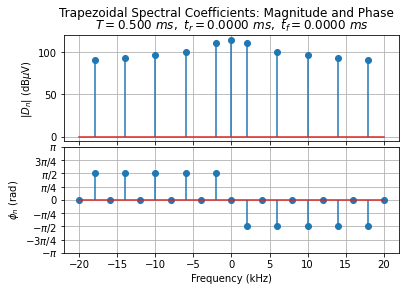

In [12]:
# Calculate some spectral elements.
N = 10
T = 1/2e3 # Note I changed T to create a 2 kHz fundamental waveform.
Trise=0.00001*T
Tfall=0.00001*T
D=0.5
A=0.5
A0=0.5
fv, Dv = trapezoidal_fourier_series_spectrum(N, T, Trise, Tfall, D, A, A0, zero_tol=1e-12)
dB = lambda y_ : 20*np.log10(np.abs(y_)) 
phase_raw = lambda y_ : (np.angle(y_))
phase = np.vectorize(lambda y_ : phase_raw(y_) if phase_raw(y_) > -np.pi*0.99 else phase_raw(y_) + 2*np.pi)

fig, axs = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.05)
ax = axs[0]
ax.stem(fv/1e3, dB(Dv/1e-6))
ax.grid(True)
ax.set_ylabel("$\|D_n\|$ (dB$\mu$V)")
ax.set_xticklabels([])
ax.set_title('$T = %.3f\ ms,\ t_r = %.4f\ ms,\ t_f = %.4f\ ms$' % tuple(np.array([T, Trise, Tfall])*1e3))

ax = axs[1]
ax.stem(fv/1e3, phase(Dv))
ax.set_yticks(np.arange(-4,5)/4*np.pi)
ax.set_yticklabels(["$-\pi$", "$-3\pi/4$", "$-\pi/2$", "$-\pi/4$", "0", "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$"])
ax.set_ylabel("$\phi_n$ (rad)")
ax.set_xlabel('Frequency (kHz)')
ax.grid(True)

fig.suptitle('Trapezoidal Spectral Coefficients: Magnitude and Phase')

f_sqr, D_sqr = fv, Dv

In [13]:
# Make one case in between the other two that is a more true trapezoidal waveform.
N = 10
T = 1/2e3 # Note I changed T to create a 2 kHz fundamental waveform.
Trise=0.1*T
Tfall=0.1*T
D=0.5
A=0.5
A0=0.5
fv, Dv = trapezoidal_fourier_series_spectrum(N, T, Trise, Tfall, D, A, A0, zero_tol=1e-12)
f_trap, D_trap = fv, Dv

/tmp/ipykernel_24756/3734412828.py:10: RuntimeWarning: divide by zero encountered in log10
  dB = lambda y_ : 20*np.log10(np.abs(y_))
/tmp/ipykernel_24756/3734412828.py:10: RuntimeWarning: divide by zero encountered in log10
  dB = lambda y_ : 20*np.log10(np.abs(y_))
/tmp/ipykernel_24756/3734412828.py:10: RuntimeWarning: divide by zero encountered in log10
  dB = lambda y_ : 20*np.log10(np.abs(y_))


Text(0.5, 0.98, 'Trapezoidal Spectral Coefficients: Magnitude and Phase')

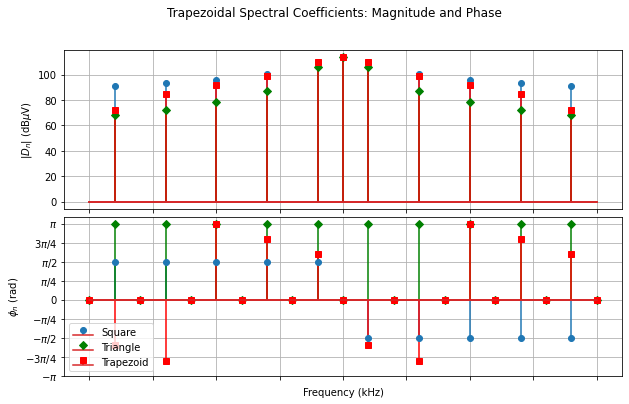

In [23]:
# Plot the two spectra together on one set of axes.
fig, axs = plt.subplots(2,1, sharex=True, figsize=(10,6))
fig.subplots_adjust(hspace=0.05)
ax = axs[0]
ax.stem(f_sqr/1e3, dB(D_sqr/1e-6))
ax.stem(f_saw/1e3, dB(D_saw/1e-6), markerfmt='Dg', linefmt='g')
ax.stem(f_trap/1e3, dB(D_trap/1e-6), label='Trapezoid', markerfmt='sr', linefmt='r')
ax.grid(True)
ax.set_ylabel("$\|D_n\|$ (dB$\mu$V)")
ax.set_xticklabels([])

ax = axs[1]
ax.stem(f_sqr/1e3, phase(D_sqr), label='Square')
ax.stem(f_saw/1e3, phase(D_saw), label='Triangle', markerfmt='Dg', linefmt='g')
ax.stem(f_trap/1e3, phase(D_trap), label='Trapezoid', markerfmt='sr', linefmt='r')
ax.set_yticks(np.arange(-4,5)/4*np.pi)
ax.set_yticklabels(["$-\pi$", "$-3\pi/4$", "$-\pi/2$", "$-\pi/4$", "0", "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$"])
ax.set_ylabel("$\phi_n$ (rad)")
ax.set_xlabel('Frequency (kHz)')
ax.grid(True)
leg = ax.legend(loc='best')

fig.suptitle('Trapezoidal Spectral Coefficients: Magnitude and Phase')

The triangle wave coefficients fall off faster than the approximate square wave coefficients.  Both have significant high frequency components, which means each will likely require a number of frequency terms to ensure a reasonable match.  Likewise, a low bandwidth channel will limit the performance of either as a signal carrier.

In [15]:
# Make one case in between the other two that is a more true trapezoidal waveform.
N = 10
T = 1/2e3 # Note I changed T to create a 2 kHz fundamental waveform.
Trise=0.01*T
Tfall=Trise
D=0.5
A=0.5
A0=0.5
fv, Dv = trapezoidal_fourier_series_spectrum(N, T, Trise, Tfall, D, A, A0, zero_tol=1e-12)

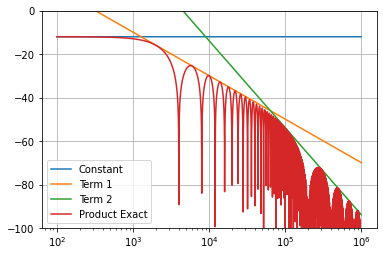

In [16]:
fv = np.logspace(2, 6, 10001) # 1 Hz to 100 kHz
C0 = A*D + 0*fv

x1 = np.pi*D*fv*T
C1 = 1.0/x1
x2 = np.pi*Trise*fv
C2 = 1.0/x2

y = C0 * np.sin(x1)/x1 * np.sin(x2)/x2

fig, ax = plt.subplots(1,1)
yfcn = lambda y_ : 20*np.log10(np.abs(y_))
ax.semilogx(fv, yfcn(C0), label='Constant')
ax.semilogx(fv, yfcn(C0*C1), label='Term 1')
ax.semilogx(fv, yfcn(C0*C1*C2), label='Term 2')
# ax.semilogx(fv, yfcn(C0*C1*C2), label='Product')
ax.semilogx(fv, yfcn(y), label='Product Exact')
leg1 = ax.legend(loc='best')

ax.set_ylim(-100,0)

ax.grid(True)

## Spectral Plots and Envelopes <a class="anchor" id="trapenvelope"></a>
### Make a function to do the Bode plot piece.

In [17]:
def trapezoidal_bode_plot(f, T, Trise=1e-15, D=0.5, A=1, ReturnCutoff=False):
  """Calculate and return a Bode plot envelope function for the magnitude spectrum of
  the trapezoidal wave described by the given parameters.  Use the frequency vector f
  and return a magnitude spectrum X."""
  Tpulse = D*T
  f1 = 1./(np.pi * Tpulse)
  f2 = 1./(np.pi * Trise)

  Xm = (A*D) \
    * np.array([1 if f_ < f1 else f1/f_ for f_ in f]) \
    * np.array([1 if f_ < f2 else f2/f_ for f_ in f])

  if ReturnCutoff:
    return Xm, f1, f2
  else:
    return Xm

-12.046997453882678 -46.025394994485744


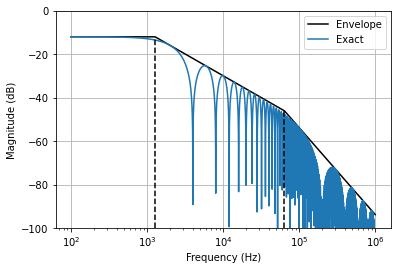

In [18]:
fv = np.logspace(2, 6, 10001) # 1 Hz to 100 kHz
C0 = A*D + 0*fv

x1 = np.pi*D*fv*T
C1 = 1.0/x1
x2 = np.pi*Trise*fv
C2 = 1.0/x2

y = C0 * np.sin(x1)/x1 * np.sin(x2)/x2
Yenv, f1, f2 = trapezoidal_bode_plot(fv, T, Trise, D, A, ReturnCutoff=True)
ii1, ii2 = np.searchsorted(fv, [f1, f2])
Yenv1, Yenv2 = Yenv[ii1], Yenv[ii2]


fig, ax = plt.subplots(1,1)
ax.set_ylim(-100,0)
ymin, ymax = ax.get_ylim()
yfcn = lambda y_ : 20*np.log10(np.abs(y_))
print(yfcn(Yenv1), yfcn(Yenv2))
ax.semilogx(fv, yfcn(Yenv), label='Envelope', color='k')
ax.semilogx(fv, yfcn(y), label='Exact')
ax.axvline(f1, ymax=(yfcn(Yenv1)-ymin)/(ymax-ymin), color='k', linestyle='--')
ax.axvline(f2, ymax=(yfcn(Yenv2)-ymin)/(ymax-ymin), color='k', linestyle='--')
leg1 = ax.legend(loc='best')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude (dB)')
ax.grid(True)

-20.00579762732343 -53.984195167926494


Text(61000.0, -105, '$f_2$')

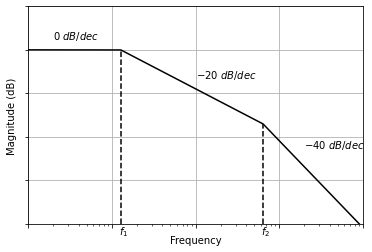

In [19]:
T = 1/2e3 # Note I changed T to create a 2 kHz fundamental waveform.
Trise=0.01*T
Tfall=Trise

fv = np.logspace(2, 6, 10001) # 1 Hz to 100 kHz
Yenv, f1, f2 = trapezoidal_bode_plot(fv, T, Trise, 0.5, 0.2, ReturnCutoff=True)
ii1, ii2 = np.searchsorted(fv, [f1, f2])
Yenv1, Yenv2 = Yenv[ii1], Yenv[ii2]


fig, ax = plt.subplots(1,1)
ax.set_xlim(1e2, 1e6)
ax.set_ylim(-100,0)
ymin, ymax = ax.get_ylim()
yfcn = lambda y_ : 20*np.log10(np.abs(y_))
print(yfcn(Yenv1), yfcn(Yenv2))
ax.semilogx(fv, yfcn(Yenv), label='Envelope', color='k')
ax.axvline(f1, ymax=(yfcn(Yenv1)-ymin)/(ymax-ymin), color='k', linestyle='--')
ax.axvline(f2, ymax=(yfcn(Yenv2)-ymin)/(ymax-ymin), color='k', linestyle='--')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True)
ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude (dB)')
ax.text(2e2, -15, '$0\ dB/dec$')
ax.text(1e4, -33, '$-20\ dB/dec$')
ax.text(2e5, -65, '$-40\ dB/dec$')
ax.text(1.2e3, -105, '$f_1$')
ax.text(6.1e4, -105, '$f_2$')

#fig.savefig('trap_bare_bode_plot.pdf')

### Spectra of Generalized Waveforms

High-speed digital design utilizes clock signals.  However, most of the signals of concern carry more information than on and off.  Such signals are no longer strictly periodic, and require analysis with a Fourier transform rather than a Fourier series. We will use the Fast-Fourier Transform (FFT) for our calculations. The `SciPy` package includes an FFT algorithm and other functions to make this job easier.  _I have written my own discrete Fourier transform algorithms before, but they are much slower than the optimized algorithms from `SciPy`.

The inputs to the functions below are time and signal vectors.  Technically, the time waveform could be replaced with sample rate.  However, I seldom plot a spectrum without first observing the time-domain waveform, which will require the time vector.  The periodic signals discussed previously in this notebook can be analyzed with FFTs, as well.  The resulting spectra will include truncation effects, associated with the discrete Fourier transform.  Longer time waveforms will approach the ideal Fourier Series form with an FFT calculation.  A higher sample rate will yield a higher maximum frequency, but a longer waveform is required to produce finer details in the spectrum.

In [20]:
# Code for FFT calculations
import scipy.fftpack as sfft

def isodd(N):
    if N % 2 == 0:
        return False
    return True

def fftfreq(N, Ts, DoubleSided = True):
    '''N = Number of points, Ts = sample rate'''
    if DoubleSided:
        return sfft.fftshift(sfft.fftfreq(N, Ts))
    else:
        Nsingle = 0
        if isodd(N):
            Nsingle = int((N+1)/2)
        else:
            Nsingle = int(N/2)
        return sfft.fftfreq(N, Ts)[:Nsingle]

def dftcalc(t, v, N=None, DoubleSided=True, **kwargs):
    """
    N = Number of samples to use in the calculation
    DoubleSided = Whether to produce a single or double sided
    response.

    Note: The non-DC terms are doubled in single-response.
    """
    t_,v_ = t,v

    L = len(v_)
    if N is None:
        N = L

    Ts = t_[1]-t_[0] # Assume a constant sample rate.

    f = fftfreq(N, Ts, DoubleSided)
    if DoubleSided:
        V = sfft.fftshift(sfft.fft(v_,N))
    else: # single sided spectrum
        V = sfft.fft(v_,N)[:len(f)]*2.
        V[0] /= 2.
    return f, V/L # Divide by L to get the right scaling

def singlesidedspectrum(t,v, N=None, **kwargs):
    return dftcalc(t,v,N,DoubleSided=False, **kwargs)

def doublesidedspectrum(t,v, N=None, **kwargs):
    return dftcalc(t,v,N,DoubleSided=True, **kwargs)

#### Spectrum of a Pseudo-Random Bit Stream

In [21]:
# Build a function to generate a pseudo-random bit stream and calculate the spectrum of it.
def unitstep(t, t0):
    return (t >= t0) * 1.0

def unitramp(t, t0):
    return unitstep(t,t0) * (t-t0)

class bitstream_t(object):
    def __init__(self, vlow, vhigh, tdelay, trise, tfall, ui, bitstring):
        '''recognized params => vlow, vhigh, tdelay, trise, tfall, ui, bitstring'''
        self.vlow = vlow
        self.vhigh = vhigh
        self.tdelay = tdelay
        self.trise = trise
        self.tfall = tfall
        self.ui = ui
        self.bitstring = bitstring
        self.bitarray = np.array([int(x) for x in bitstring])

        # I added a zero at the beginning to show no transitions in the initial time.
        # I'm not sure I like that, but I am not certain I like the alternative either.
        #self.transitions = np.concatenate([np.array([0,]), self.bitarray[1:] - self.bitarray[:-1]])
        self.transitions = np.roll(self.bitarray, 1) - self.bitarray

        self.Nbits = len(self.bitstring)
        self.tbitstart = np.arange(self.Nbits) * self.ui # create a list of bits to work from.

    def value(self, time):
        '''tdelay shifts the time before any value is calculated.'''
        t = (time - self.tdelay) * (time>self.tdelay)
        r = unitramp # just an alias

        ibit = np.searchsorted(self.tbitstart, time, side='right')-1 # which bit(s) are we in?
        if type(ibit) == np.ndarray:
            lam0 = np.array([np.sum(self.transitions[:ibit0]) for ibit0 in ibit])
        else:
            lam0 = np.sum(self.transitions[:ibit])

        vinit_value = (1-lam0)*self.vlow + lam0*self.vhigh

        t0 = self.tbitstart[ibit] # get the offset for the ramp
        vrising = (self.vhigh-self.vlow)/self.trise * (r(t,t0) - r(t,t0+self.trise))
        vfalling = (self.vhigh-self.vlow)/self.tfall * (r(t,t0) - r(t,t0+self.tfall))
        vstep_value = (self.transitions[ibit] > 0)*vrising - (self.transitions[ibit] < 0)*vfalling
        # If the transition = 0, do nothing.  Keep the vinit_value.
        return vinit_value + vstep_value




Create a stream of random bits.

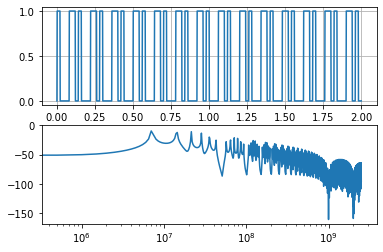

In [22]:
tr = 1e-9
tf = 1e-9
ui = 1./50e6
bstream0 = bitstream_t(0, 1, 0, tr, tf, ui, '0111001'*20)

t = np.linspace(0, ui*100, int(1e4 + 1))
v = bstream0.value(t)

tfcn = lambda t_ : t_*1e6 # us
ffcn = lambda f_ : f_/1e6 # MHz
db = lambda x_ : 20*np.log10(np.abs(x_))

fig, axs = plt.subplots(2,1)
ax = axs[0]
ax.plot(tfcn(t),v)
ax.grid(True)

f, V = singlesidedspectrum(t, v)
axm = axs[1]
axm.semilogx(f, db(V))
